#### Import Tensorflow etc

In [64]:
# Import what we need to train our model
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np


## Loading the data from the directories and preprocess it for training


In [65]:
# Saving the datasets in variables
train_dir = '/Users/olle/Downloads/final_symbols_split_ttv/train'
val_dir = '/Users/olle/Downloads/final_symbols_split_ttv/val'
test_dir = '/Users/olle/Downloads/final_symbols_split_ttv/test'



#### Setting the parameters for loading the dataset

In [66]:

batch_size = 32 # Determines the number of images processed at once (in one batch) during training.
# Neural networks train more efficiently on mini-batches of data rather than on single images or the entire dataset at once.

# Height and width defines the dimensions to which each image will be resized
img_height = 28
img_width = 28
#  Neural networks require inputs of consistent shape, so images of different sizes must be resized or cropped to match.

#  The choice of image size affects the model's complexity. Smaller images reduce the amount of data the model has to process,
#  leading to faster training times but potentially less detail.

In [67]:
# Load training data
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',  # Automatically infer labels from the subdirectory names
    label_mode='int',   # Label as integers (suitable for categorical cross-entropy)
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True #The dataset should be shuffled randomly each time it is iterated over during training
)

class_names = train_dataset.class_names  # Automatically inferred from subdirectory names

Found 42749 files belonging to 14 classes.


In [68]:
# Load validation data
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_height, img_width)
)

Found 5337 files belonging to 14 classes.


In [69]:
# Load test data
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_height, img_width)
)

Found 5356 files belonging to 14 classes.


### Preprocess and Prepare for Training

In [70]:
# To improve training, it's helpful to normalize pixel values and cache the data for performance.

# Normalize the pixel values to [0, 1] from [0, 255]
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Applies normalization_layer to all batches of data
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# The combination of cache() and prefetch() optimizes the data pipeline, improving training and inference speed by minimizing the
# time spent waiting for data.

# cache(): Stores the dataset in memory after the first epoch
# prefetch(): Preloads batches of data into memory while the model is training on the current batch.
# autotune setting: automatically chooses the best prefetching buffer size ( Its a constand provided by tensorflow )

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

### Visualize some data to see that everything works as expected

The following code takes one batch of images and labels from train_dataset.
It loops over the first 9 images in that batch and displays them in a 3x3 grid.
The images are displayed with their corresponding class names as titles, and the axes are hidden for better readability.

2024-11-11 14:39:43.050280: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


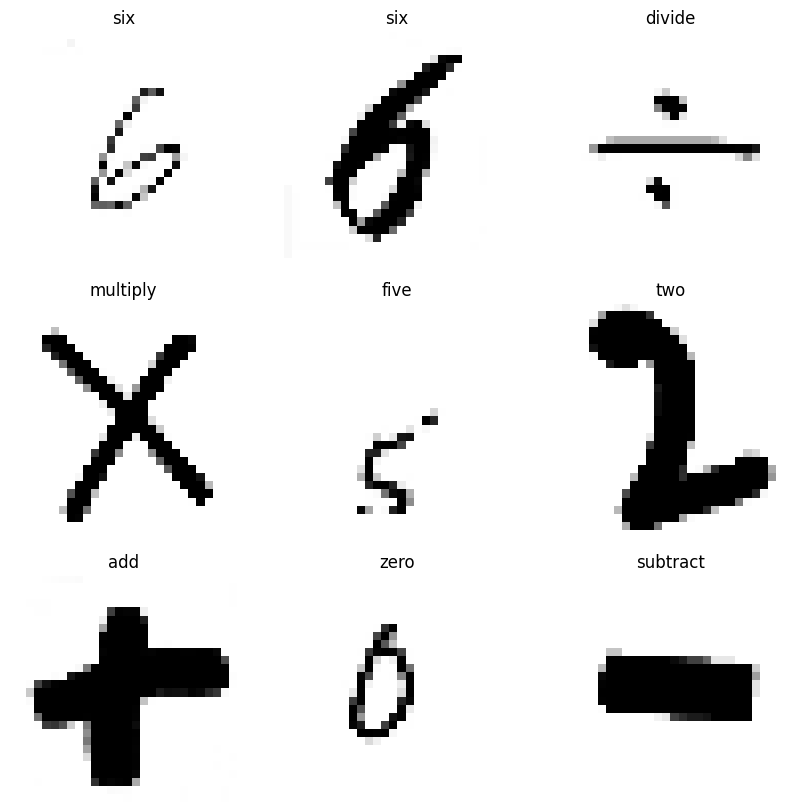

In [71]:


plt.figure(figsize=(10, 10)) # Creating a figure
for images, labels in val_dataset.take(1): # takes one batch of data from the train_dataset
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1) # Creates a subplot in a 3x3 grid and places the next image in the i+1 position.
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        # .numpy(): Converts the TensorFlow tensor to a NumPy array for compatibility with Matplotlib
        # .squeeze(): Removes single-dimensional entries ( if the image is shaped (height, width, 1), it becomes (height, width) )
        # cmap='gray': Displays the image in grayscale mode
        plt.title(class_names[labels[i]]) # Sets the title of each subplot to the class name corresponding to the label of the i-th image.
        plt.axis('off') # Hides the axis for a cleaner visualization.
plt.show() #  Renders and displays the plotted figure

# To be clear, the grid with the images is just for me as a devveloper to view. To make sure everything looks and works as expected

##  Building the Model

### Import from keras

In [72]:
from keras import Sequential, Input
from keras.api.layers import *

### Construct the model

This sequential model has multiple layers that process the image data step by step.

In [73]:
model = Sequential([
    Input(shape=(img_height, img_width, 1)),
    # The input layer does not perform any computation; it simply tells the model the shape of incoming images. 1 indicates grayscale images

    Conv2D(16, (3, 3), activation='relu'),
    # This layer applies 16 filters (or kernels) to the input image
    # (3, 3): Each filter is a 3x3 matrix, sliding over the image and detecting specific patterns, like edges.
    # This operation produces 16 new images (one for each filter), each representing a feature map.

    # Think of filters as small windows that detect certain features in the image,
    # such as horizontal or vertical lines. The more filters, the more features it can learn

    # The ReLU (Rectified Linear Unit) activation introduces non-linearity,
    # which allows the network to learn complex patterns by setting all negative values in the feature maps to zero

    MaxPooling2D(pool_size=(2, 2)),
    # Pooling Size (2, 2): This layer takes the maximum value in each 2x2 window, reducing the spatial dimensions by half.
    # For example, if the input to this layer is (28, 28), the output will be (14, 14)
    # The purpose is to help this layer reduce the amount of computation and helps the model focus on the most important features.

    Conv2D(32, (3, 3), activation='relu'),
    # Applies 32 filters of size (3, 3) to the downsampled feature maps from the previous layer,
    # enabling the model to detect more complex patterns by building on the simpler features found by the first layer

    MaxPooling2D(pool_size=(2, 2)),
    # This layer further reduces the spatial dimensions by half again, reducing the overall feature map size.

    Flatten(),
    # Converts the 2D feature maps into a 1D vector, making it ready for the fully connected dense layers.
    # The resulting 1D vector is passed to dense layers for classification.

    Dense(64, activation='relu'),
    # A fully connected layer with 64 neurons, which learns to combine the high-level features detected
    # by the previous layers to make decisions
    # Like before, the ReLU function allows the model to learn more complex patterns by introducing non-linearity.

    Dense(14, activation='softmax')
    # The final layer, which outputs probabilities for each of the 14 classes (10 digits + 4 operators)
    # Converts the raw scores for each class into probabilities that sum to 1, allowing the network to assign a confidence score to each class.
])

### Compiling the Model

In [74]:
model.compile(
    optimizer='adam',
    # The Adam optimizer adjusts the model's weights to minimize the loss function.
    # It’s adaptive, efficient, and commonly used for deep learning tasks.
    loss='sparse_categorical_crossentropy',
    # The loss function measures the difference between the true labels and the predicted probabilities
    # The reason sparse is used, is because the labels are integers ( 0, 1, 2, etc ) instead of one-hot encoded vectors
    metrics=['accuracy']
    # This tracks the accuracy during training and evaluation, showing the proportion of correct predictions.
)

## Train the Model

Training Dataset: helps the model learn patterns in the data.

Validation Dataset: assesses how well the model generalizes to unseen data, acting as a quality check against overfitting.

Epochs: control the training duration, affecting the balance between underfitting and overfitting.

In [77]:
history = model.fit(
    train_dataset,
    # The training dataset is the main set of data used by the model to learn the relationships between inputs and outputs.
    validation_data=val_dataset,
    # Using a validation dataset helps to prevent overfitting by allowing to monitor the model’s performance on data it hasn’t seen before.
    # After each epoch, the model evaluates its performance on the validation dataset,
    # giving an indication of how well it is generalizing to unseen data
    epochs=10
    # With each epoch, the model updates its weights to reduce the loss based on the training data,
    # ideally improving its accuracy and generalization
)

Epoch 1/10
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9624 - loss: 0.1269 - val_accuracy: 0.9605 - val_loss: 0.1268
Epoch 2/10
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9723 - loss: 0.0955 - val_accuracy: 0.9627 - val_loss: 0.1178
Epoch 3/10
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9777 - loss: 0.0745 - val_accuracy: 0.9666 - val_loss: 0.1097
Epoch 4/10
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9815 - loss: 0.0592 - val_accuracy: 0.9687 - val_loss: 0.1133
Epoch 5/10
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9852 - loss: 0.0476 - val_accuracy: 0.9702 - val_loss: 0.1144
Epoch 6/10
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9883 - loss: 0.0400 - val_accuracy: 0.9726 - val_loss: 0.1089
Epoch 7/10
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9883 - loss: 0.0359 - val_accuracy: 0.9753 - val_loss: 0.0953
Epoch 8/10
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9897 - loss: 0.0294 - 

#### Accuracy and loss over epochs to check for signs of overfitting 

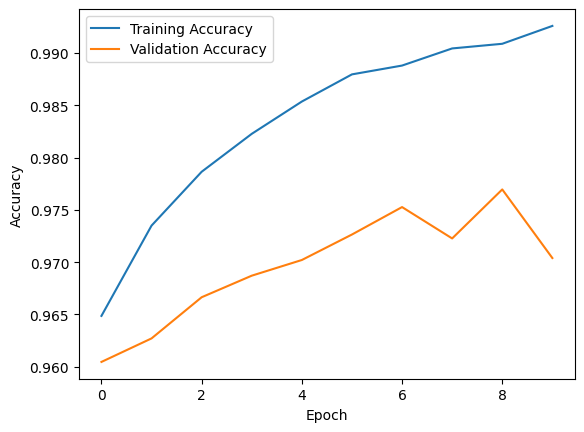

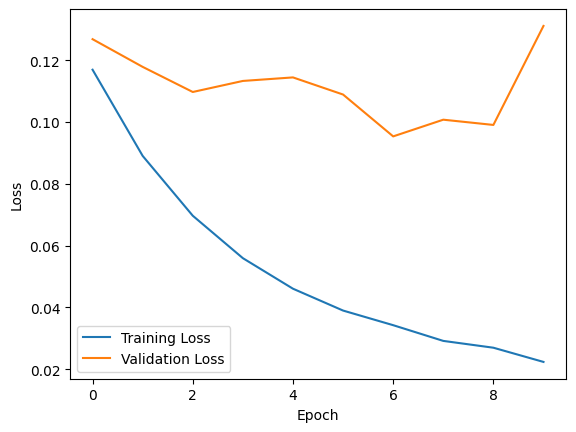

In [78]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()